In [1]:
from elasticsearch import Elasticsearch

In [2]:
es = Elasticsearch(
    "http://localhost:9200",
#     basic_auth=("elastic","LQym+efHnUy9DbT-jtD2"),
#     ca_certs="/Users/abidsaudagar/Personal/yt1_semantic_search/elasticsearch-8.9.1/config/certs/http_ca.crt"
)
client = es.info()
print(client)

{'name': 'ca087fcea954', 'cluster_name': 'docker-cluster', 'cluster_uuid': '2U6tD895Rp2Oaa1a4GKKNA', 'version': {'number': '8.15.0', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '1a77947f34deddb41af25e6f0ddb8e830159c179', 'build_date': '2024-08-05T10:05:34.233336849Z', 'build_snapshot': False, 'lucene_version': '9.11.1', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'}


## Prepare the data

In [12]:
import pandas as pd
from semantic_text_splitter import TextSplitter
splitter = TextSplitter(1000)
df = pd.read_csv("output_try1st(1).csv",encoding="latin-1")
chunks = splitter.chunks(df["Content"][35])
for i, chunk in enumerate(chunks):
    print(f"{i} :  {chunk}")

0 :  ////////////////////////////////////////////////////////////////////////////////<-80 chars
// Comments for the following logic
wire   signal1;
assign signal1 = ^signal2;
signal3;
reg [12:0]
always @( posedge clk19 or negedge rst_ )
begin
if (!rst_)
begin
signal3 <= 13âb0;
end
else
begin
if (|signal3)
begin
signal3[2] <= signal4;
end
:
:
end
end


In [29]:
df.isna().value_counts()

Type   Session  Content  Summary  SummaryVector
False  False    False    False    False            59
                True     False    False             1
Name: count, dtype: int64

In [30]:
df.fillna("None", inplace=True)
df.describe()

,Type,Session,Content,Summary,SummaryVector
count,60,60,60,60,60
unique,3,41,57,59,58
top,Text,Comments,Empty section.\n,if ((((signal1 == 2âb10) &&\n(signal2 != c_...,[-2.63710171e-02 5.56130242e-03 -1.14758890e-...
freq,29,5,3,2,2


In [ ]:
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain.embeddings import OllamaEmbeddings
from langchain.chat_models import ChatOllama
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

template = """
You are an assistant tasked with summarizing tables as html and text.
Give a concise summary of the table or text. 

Respond only with the summary, no additionnal comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is.

Table or text chunk: {context}

"""

prompt = ChatPromptTemplate.from_template(template)

# Define RAG pipeline with metadata-aware retrieval

prompting = ChatOllama(model="llama3.2:1b")
text_summarizes = []
for i in range(len(df)):
  try:
    if df.loc[i, 'Type'] == "Code":
        df.loc[i, 'Summary'] = df.loc[i, 'Content']  # Fix here
        continue
    
    text_summarize = f"This is {df['Type'].iloc[i]} of Session {df['Session'].iloc[i]} \n"
    rag_chain = (
        RunnablePassthrough()  
        | prompt
        | prompting
        | StrOutputParser()
    )
    text_summarize += rag_chain.invoke({"context": df.loc[i, 'Content']})  # This line is correct
    df.loc[i, "Summary"] = text_summarize       
  except Exception as e:
    print(f"error in {i}: {e}")

df    

## Convert the relevant field to Vector using BERT model

In [20]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-mpnet-base-v2')

In [33]:
df["SummaryVector"] = df["Summary"].apply(lambda x: model.encode(x))

In [ ]:
df

In [ ]:
df.to_csv('output.csv', index=False)

In [16]:
df = pd.read_csv('output.csv')

## Create new index in ElasticSearch!

In [34]:
from indexMapping import indexMapping
index_name = 'rag'
if es.indices.exists(index=index_name):
  es.indices.delete(index=index_name)
  print(f"Index '{index_name}' deleted.")
es.indices.create(index=index_name, mappings=indexMapping)

Index 'rag' deleted.


ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'rag'})

## Ingest the data into index

In [35]:
record_list = df.to_dict("records")

In [36]:
for record in record_list:
    try:
        es.index(index="rag", document=record)
    except Exception as e:
        print(e)

In [5]:
es.count(index="content_retrieve")

ObjectApiResponse({'count': 30, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}})

In [21]:
index_name = "content_retrieve"
query = {
    "query": {
        "match_all": {}
    },
    "size": 10000  # Giới hạn mặc định của Elasticsearch là 10,000, có thể tăng bằng cách config max_result_window
}

response = es.search(index=index_name, body=query)

# Lấy dữ liệu
data1 = [hit["_source"] for hit in response["hits"]["hits"]]
print(data1)
data = []

from indexMapping import indexMapping
index_name = 'rett'
if es.indices.exists(index=index_name):
  es.indices.delete(index=index_name)
  print(f"Index '{index_name}' deleted.")
  
es.indices.create(index=index_name, mappings=indexMapping)

for i in range(len(data1)):
    print(data1[i]['content'])
    # assert 1 == 0
    data.append({"Content": data1[i]['content'],  "Vector": model.encode(data1[i]['content'])})  
    
for record in data:
    try:
        es.index(index="rett", document=record)
        print(record)
    except Exception as e:
        print(e)

index_name = "rett"

response = es.search(index=index_name, body=query)

# Lấy dữ liệu
data = [hit["_source"] for hit in response["hits"]["hits"]]
print(data)
# data = []

[{'content': 'Arrive Technologies Inc. Guidelines\nATVN\nVerilog Coding Standards\nAbstract: This document describes the Verilog Programming Style to be used in the logic development. A Set of conventions is described covering various constructs of the language. These conventions are intended to provide a high level of uniformity in the code produced by different programmers thus achieving readability and maintainability.\nRevision: 3.1 Last Updated: 03-Aug-06Author:AT ASIC Design Group\nThis controlled document is the proprietary of Arrive Technologies Inc. Any duplication, reproduction, or transmission to unauthorized parties is prohibited. Copyright ©2006\nDocument History\n<table>\n<tr><td  >Revision </td><td  >Date </td><td  >Description </td></tr>\n<tr><td  >1.0 </td><td  >May 2001 </td><td  >Initial Version </td></tr>\n<tr><td  >2.0 </td><td  >Jan 2003 </td><td  >Changed for new RED-BLUE chips </td></tr>\n<tr><td  >3.0 </td><td  >July 2003 </td><td  >After a review on July-29-03

## Search the data

In [41]:
input_keyword = "Reset Signal Name"
vector_of_input_keyword = model.encode(input_keyword)

max_candi = es.count(index="rett")["count"]

query_vector = model.encode(input_keyword).tolist()
prompt = "6.4. RTL Mandatory"
# Perform the search with KNN and Match query
max_candi = es.count(index="rett")["count"]
if max_candi > 0:
    query = {
    "field" : "Vector",
    "query_vector" : model.encode(prompt),
    "k" : 2,
    "num_candidates" : max_candi , 
    # "min_score": 0.4
}
res = es.knn_search(index="rett", knn=query , source=["Content"])

# print(res['hits']['hits'])

for data in res['hits']['hits']:
    print(data['_score'])
    print(data['_source']['Content'])


0.7513943
6.4. RTL Mandatory
Because of synthesis reasons, there are obligatory avoidances as follows in RTL coding.
ll comment in all Verilog files has to be in English. Do not use the include statement in RTL source code. The include statement is replaced by forcing a simulator to search included verilog files. o not use the display statement in RTL source code. o not assign one Register in two different always blocks.Do not duplicate a conditional expression more than one place. For example:
assign cond_true =request1 | request2 |request3;
st//using cond_true in the 1 always statementalways @(posedge clk or negedge rst_)beginif (!rst_)begin end else beginstatement(s)if (cond_true)reg1 <=2’b10; //DO NOT duplicate like “if (request1|..)"
end
end
nd//using cond_true in the 2 condition statement//DO NOT duplicate assign wire3 cond_true regtrue :regfalse;//like “=(request1| ..)?”
0.69265914
<table>
<tr><th  rowspan=8 >Revision  3.1  3.0 </th><th></th><th  >Changes </th></tr>
<tr><td  >1.

C:\Users\Song\AppData\Local\Temp\ipykernel_23764\3417638277.py:18: GeneralAvailabilityWarning: This API is in technical preview and may be changed or removed in a future release. Elastic will work to fix any issues, but features in technical preview are not subject to the support SLA of official GA features.
  res = es.knn_search(index="rett", knn=query , source=["Content"])
C:\Users\Song\AppData\Local\Temp\ipykernel_23764\3417638277.py:18: ElasticsearchWarning: The kNN search API has been replaced by the `knn` option in the search API.
  res = es.knn_search(index="rett", knn=query , source=["Content"])


In [ ]:
from typing import Iterator
from agno.agent import Agent, RunResponse  # noqa
from agno.models.ollama import Ollama
from textwrap import dedent
from agno.run.response import RunResponse
from rich.pretty import pprint
instruction = dedent("""\
    You are a specialized LLM for processing and formatting code, especially in C, Verilog, and hardware-related programming languages. Your task is to automatically split and properly format code to improve readability while preserving comments and ensuring correct syntax.

    **IMPORTANT**: Only return the **Expected Output**. Do not include explanations, reasons, or any additional comments.

    📌 **General Rules for Code Formatting**
    - Each statement or declaration must be on a separate line if not already formatted correctly.
    - Preserve and correctly associate comments (`//` or `/* ... */`) with the related code.
    - Maintain proper indentation and ensure valid syntax.
    - Support C, Verilog, and embedded programming languages.

    --- 

    **1️⃣ Verilog/SystemVerilog Formatting Rules**
    - Split signal declarations (`wire`, `reg`, `logic`, `input`, `output`) into separate lines.
    - Maintain structured blocks like `begin ... end`, `case ... endcase`, `if ... else`.
    - Ensure comments belong to the correct declaration or statement.



    📌 **Summary**
    - Ensure proper formatting for readability and debugging.
  - Apply language-specific line breaks for Verilog, C, and Embedded C.
    - Maintain comments, indentation, and correct syntax.
    - Ensure statements and blocks are structured logically without excessive concatenation.
""")


agent = Agent(model=Ollama(id="llama3.2:1b"), 
              description = "You are a specialized LLM for processing and formatting Verilog code. Your task is to split and properly format signal declarations (wire, reg, etc.) so that each signal appears on a separate line while preserving comments (// ...) and ensuring correct Verilog syntax." ,
              instructions = instruction,
              markdown=True)
# Print the response in the terminal
# agent.print_response(dedent("""
                            
#                             """))
# run_response: Iterator[RunResponse] = agent.run(, stream=True)
# for chunk in run_response:
#     print(chunk.content)

structured_output_response: RunResponse = agent.run("""
Because of synthesis reasons, there are obligatory avoidances as follows in RTL coding.
ll comment in all Verilog files has to be in English. Do not use the include statement in RTL source code. The include statement is replaced by forcing a simulator to search included verilog files. o not use the display statement in RTL source code. o not assign one Register in two different always blocks.Do not duplicate a conditional expression more than one place. For example:
assign cond_true =request1 | request2 |request3;
st//using cond_true in the 1 always statementalways @(posedge clk or negedge rst_)beginif (!rst_)begin end else beginstatement(s)if (cond_true)reg1 <=2’b10; //DO NOT duplicate like “if (request1|..)"
end
end
nd//using cond_true in the 2 condition statement//DO NOT duplicate assign wire3 cond_true regtrue :regfalse;//like “=(request1| ..)?”
""")

print(structured_output_response.content)

```
ll comment in all Verilog files has to be in English.

// 
```


<p>INFEENCE</p>

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain.embeddings import OllamaEmbeddings
from langchain.chat_models import ChatOllama
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

template = """
You are an expert in  IC design.  Your answer can based on code or just theory
Answer the question based **only** on the following context:
{context}
Question: {question}
"""  

llm = ChatOllama(
    model = "llama3.2:1b",
    temperature = 0,
)
prompt = ChatPromptTemplate.from_template(template)

try:
  context = '\n'.join(item['_source']['Content'] for item in res["hits"]["hits"])
  # text_summarize = f"This is {df['Type'].iloc[i]} of Session {df['Session'].iloc[i]} \n"
  rag_chain = (
  RunnablePassthrough()  
  | prompt
  | prompting
  | StrOutputParser()
)
  output = rag_chain.invoke({"context": context, "question":"example code for horizontal spacing"})
  print(output)

except Exception as e:
  print(f"error in {i}: {e}")

Here is an example of code with proper indentation, blank lines for readability, and correct formatting:

```
module RegEx;
  // assign a variable 'reg_ex' and initialize it to the result of val1 OR val2
assign reg_ex = (val1 | val2);
```

This code demonstrates how to properly use spaces around binary operators and commas, and aligns continuation lines with their starting points.


In [ ]:
from langchain.chat_models import ChatOllama
from pydantic import BaseModel, Field

llm = ChatOllama(model="llama3.2:1b")

C:\Users\MSI\AppData\Local\Temp\ipykernel_6720\2172879952.py:4: LangChainDeprecationWarning: The class `ChatOllama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import ChatOllama``.
  llm = ChatOllama(model="llama3.2:1b")


In [ ]:
from typing_extensions import Literal, TypedDict
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START, END


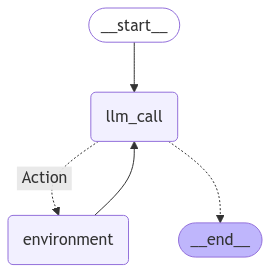

================================ Human Message =================================

Add 3 ; 4 and subtract 7 ; 2
================================== Ai Message ==================================

To solve this problem, I'll follow the order of operations (PEMDAS):

1. Add 3 and 4: 3 + 4 = 7
2. Subtract 7 from the result: 7 - 7 = 0

So the final answer is 0.


In [ ]:
from langchain_core.tools import tool
from langchain.chat_models import ChatOpenAI, ChatOllama
from langgraph.graph import StateGraph, START, END
from langchain_experimental.llms.ollama_functions import OllamaFunctions
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage
from IPython.display import Image, display

# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = ChatOllama(
    model = "llama3.2:1b",
    temperature=0,
    tools = [divide]
)


from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage


# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="Add 3 ; 4 and subtract 7 ;")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

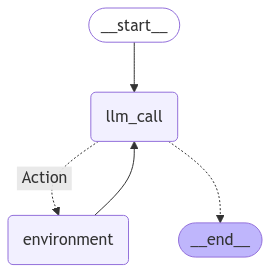

================================ Human Message =================================

Add 3 and 4 then subtract 7 and 2
================================== Ai Message ==================================

To solve this problem, I'll follow the order of operations (PEMDAS):

1. Add 3 and 4: 3 + 4 = 7
2. Subtract 7 from the result: 7 - 7 = 0
3. Subtract 2 from the result: 0 - 2 = -2

The final answer is -2.


In [ ]:


from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage


# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="Add 3 and 4 then subtract 7 and 2")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

In [ ]:
from typing_extensions import Literal, TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from langchain_experimental.llms.ollama_functions import OllamaFunctions
# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        description="The next step in the routing process"
    )

llm_no_deep = ChatOpenAI(api_key="ollama", model="llama3.2:1b",  temperature=0, base_url="http://localhost:11434/v1")
structured_llm = llm_no_deep.with_structured_output(Route)

llm = ChatOllama(model="llama3.2:1b", temperature  = 0)

# State
class State(TypedDict):
    input: str
    decision: Literal["poem", "story", "joke"]
    output: str

# Nodes
def llm_call_1(state: State):
    """Write a story"""
    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""
    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""
    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""
    
    # Run the augmented LLM with structured output to serve as routing logic
    prompt = PromptTemplate(
    input_variables=["input"],
    template="""
    You must categorize the user's request as either 'code', 'content', or 'image'.
    Only return one of these three words exactly, nothing else.

    User request: {input}
    Response: """,
)
    chain = prompt | structured_llm
    decision = chain.invoke({"input": state["input"]})

    return {"decision": decision.step}


# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"


# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
# display(Image(router_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = router_workflow.invoke({"input": "Write me a poem about cats"})
print(state["output"])


Whiskered felines, eyes so bright,
Purrs in the morning, purrs at night.
Their soft fur, a gentle touch,
Inviting snuggles, and a loving clutch.

With claws that scratch, and ears so fine,
They prowl through shadows, with stealthy design.
Their little noses, twitching with glee,
As they explore, wild and carefree.

In sunbeams bright, they bask and play,
Chasing dreams, in a lazy day.
Their playful pounces, bring joy to all,
A symbol of love, that stands tall.

At night, when darkness falls,
They curl up tight, with a gentle call.
Their soft purrs, a lullaby sweet,
As they dream of mice, and secrets to keep.

Cats, oh cats, with your mystery and charm,
You rule our hearts, with your feline form.
A symbol of independence, and love so true,
Forever in our lives, a part of me and you.


In [ ]:
# Graph state
from typing_extensions import Literal, TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from langchain_experimental.llms.ollama_functions import OllamaFunctions
from langchain_openai import ChatOpenAI

llm_no_deep = ChatOpenAI(api_key="ollama", model="qwen2.5:1.5b",  temperature=0, base_url="http://localhost:11434/v1")
structured_llm = llm_no_deep.with_structured_output(Route)

class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str


# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not and easy to understand.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )

# Augment the LLM with schema for structured output
evaluator = llm_no_deep.with_structured_output(Feedback)
llm = ChatOllama(model="llama3.2:1b", temperature  = 0)

# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""
    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""
    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    print(grade)
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""
    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"


# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
# display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = optimizer_workflow.invoke({"topic": "Cats"})
print(state["joke"])

grade='funny' feedback='The joke is funny because it combines an animal (cat) with a musical instrument (purse), creating a playful and unexpected connection.'
Why did the cat join a band?

Because it wanted to be the purr-cussionist.


In [ ]:
import json
from typing import List, Literal, Optional

import tiktoken
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.documents import Document
from langchain_core.embeddings import Embeddings
from langchain_core.messages import get_buffer_string
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import ChatOpenAI
from langchain_openai.embeddings import OpenAIEmbeddings
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode

C:\Users\MSI\AppData\Roaming\Python\Python310\site-packages\pydantic\_internal\_generate_schema.py:775: UserWarning: Mixing V1 models and V2 models (or constructs, like `TypeAdapter`) is not supported. Please upgrade `TavilySearchAPIWrapper` to V2.
  warn(


In [ ]:
import uuid

def get_user_id(config: RunnableConfig) -> str:
    user_id = config["configurable"].get("user_id")
    if user_id is None:
        raise ValueError("User ID needs to be provided to save a memory.")
    return user_id

@tool
def save_recall_memory(memory: str, config: RunnableConfig) -> str:
    user_id = get_user_id(config)
    document = Document(
        page_content=memory, id=str(uuid.uuid4()), metadata={"user_id": user_id}
    )
    recall_vector_store.add_documents([document])
    return memory

@tool
def search_recall_memories(query: str, config: RunnableConfig) -> List[str]:
    user_id = get_user_id(config)

    def _filter_function(doc: Document) -> bool:
        return doc.metadata.get("user_id") == user_id
    documents = recall_vector_store.similarity_search(
        query, k=3, filter=_filter_function
    )
    return [document.page_content for document in documents]




In [ ]:
# %pip install agno, groq, elasticsearch, indexMapping
from elasticsearch import Elasticsearch
from agno.agent import Agent, RunResponse  
# from agno.models.deepseek import DeepSeek
# from agno.utils.pprint import pprint_run_response
from elasticsearch import Elasticsearch
# from agno.models.groq import Groq #NOTE! This is the Groq model
from agno.embedder.sentence_transformer import SentenceTransformerEmbedder
from sentence_transformers import SentenceTransformer
# from agno.embedder.ollama import OllamaEmbedder
from agno.models.ollama import Ollama
from datetime import datetime, timezone

es = Elasticsearch("http://localhost:9200")
user_id = "agno"
conversation = []
index_mapping = {
        "properties": {
            "user_id": {"type": "keyword"}, 
            "timestamp": {"type": "date"},  # Time
            "messages": {
                "type": "nested",  #stack_conversation
                "properties": {
                    "role": {"type": "keyword"},  # "user" / "assistant"
                    "content": {"type": "text"}   # Nội dung 
                }
            },
            "messages_vector": {
                "type":"dense_vector",
                "dims": 768,
                "index":True,
                "similarity": "l2_norm"
            }
        }
}
# ------------------------------
index_name = 'tryagno'
if es.indices.exists(index=index_name):
  es.indices.delete(index=index_name)
#   print(f"Index '{index_name}' deleted.")
es.indices.create(index=index_name, mappings=index_mapping)
es.ping()
# ------------------------------
print("Hi, what do you need?")


# ------------------------------
while True:
    embedding_model = SentenceTransformer('all-mpnet-base-v2')
    def embed_query(text):
        return embedding_model.encode(text)
    sc = input()
    if sc == "stop":
        print("Goodbye!")
        break
    print("User:",sc)
    conversation = {"role": "user", "content": sc}
    # ------------------------------
    # Store the conversation in Elasticsearch
    try:
        es.index(index="tryagno", document={"user_id": user_id, "timestamp": datetime.now(timezone.utc) , 
        "messages": conversation, "messages_vector": embed_query(conversation["content"])})
        print("Debugging before AI response")

# print(" Data successfully stored in Elasticsearch!")
    except Exception as e:
        print(f"⚠️ Error saving to Elasticsearch: {e}")
        break
    max_candi = es.count(index="tryagno")["count"]
    for i in range(max_candi):
        try:
            stored_data = es.search(index="tryagno", query={"match": {"user_id": user_id}})
            print(stored_data["hits"]["hits"][i]["_source"]["messages"] if stored_data["hits"]["hits"] else [])
        except Exception as e:
            print(f"⚠️ Pass {e}")
    # ------------------------------
    history = []
    
    try:
        # Perform KNN search to retrieve only the most relevant past messages
        response = es.knn_search(
            index="tryagno",
            knn={
                "field": "messages_vector",  # Assuming messages are vectorized
                "query_vector": embed_query(sc),  # Embed the query
                "k": 8,  # Retrieve top 5 most relevant messages
                "num_candidates": 50
            },
            
            source=["messages"],  # Fetch only the "messages" field
        )
        print("Debugging after KNN search")
        print(response)
    except Exception as e:
        print(f"⚠️ Error retrieving data: {e}")
        break

    # Extract the relevant messages
    history = [hit["_source"]["messages"] for hit in response["hits"]["hits"]]
    # ------------------------------
    # Create an agent
    agent = Agent(
        model=Ollama(id="llama3.2:1b"),
        context={"memory": history},
        instructions="You are an assistant to help user with their queries/requests/questions. You can use 'context' to remember the conversation history. Note that your role is 'assistant' and user's role is 'user' ",
        add_context=True,
        markdown=True,
    )
    # ------------------------------
    run_mess = agent.run(sc)
    new_messages = [{"role": msg.role, "content": str(msg.content)} for msg in (run_mess.messages or [])]
    print("debug:")
    print(new_messages)
    # for i in range(len(new_messages)):
    try:
        es.index(index="tryagno", document={"user_id": user_id, "timestamp": datetime.now(timezone.utc),
        "messages": new_messages[-1], "messages_vector": embed_query(new_messages[-1]['content'])})            
    # print(" AI response stored in Elasticsearch!")
    except Exception as e:
        print(f"⚠️ Error saving AI response: {e}")
        break
    # ------------------------------
    print("Debugging after AI response")
    max_candi = es.count(index="tryagno")["count"]
    for i in range(max_candi):
        try:
            stored_data = es.search(index="tryagno", query={"match": {"user_id": user_id}})
            print(i)
            print(stored_data["hits"]["hits"][i]["_source"]["messages"] if stored_data["hits"]["hits"] else [])   
        except Exception as e:
            print(f"⚠️ Pass {e}")
    '''======================================='''
    print("\n",run_mess.messages[-1].content)
    
# ------------------------------

Hi, what do you need?
User: hello my name is Song
Debugging before AI response


C:\Users\Song\AppData\Local\Temp\ipykernel_4476\2940471864.py:81: GeneralAvailabilityWarning: This API is in technical preview and may be changed or removed in a future release. Elastic will work to fix any issues, but features in technical preview are not subject to the support SLA of official GA features.
  response = es.knn_search(
C:\Users\Song\AppData\Local\Temp\ipykernel_4476\2940471864.py:81: ElasticsearchWarning: The kNN search API has been replaced by the `knn` option in the search API.
  response = es.knn_search(


Debugging after KNN search
{'took': 7, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 1, 'relation': 'eq'}, 'max_score': 1.0, 'hits': [{'_index': 'tryagno', '_id': '1k-napUBI7Xxwvj30N0w', '_score': 1.0, '_source': {'messages': {'role': 'user', 'content': 'hello my name is Song'}}}]}}
debug:
[{'role': 'system', 'content': "<instructions>\nYou are an assistant to help user with their queries/requests/questions. You can use 'context' to remember the conversation history. Note that your role is 'assistant' and user's role is 'user' \n</instructions>\n\n<additional_information>\n- Use markdown to format your answers.\n</additional_information>"}, {'role': 'user', 'content': 'hello my name is Song\n\n<context>\n{\n  "memory": [\n    {\n      "role": "user",\n      "content": "hello my name is Song"\n    }\n  ]\n}\n</context>'}, {'role': 'assistant', 'content': "Hello Song,\n\nNice to meet you.\n\nAs per our conversation hi

KeyboardInterrupt: 

In [ ]:
from mem0 import MemoryClient

client = MemoryClient()

ValueError: Mem0 API Key not provided. Please provide an API Key.

In [ ]:
from agno.agent import Agent, AgentMemory, RunResponse
from agno.memory.db.postgres import PgMemoryDb
from agno.models.ollama.chat import Ollama
from agno.storage.agent.postgres import PostgresAgentStorage
import os
from agno.embedder.ollama import OllamaEmbedder
from agno.memory.classifier import MemoryClassifier
from agno.memory.summarizer import MemorySummarizer
from agno.memory.manager import MemoryManager
from textwrap import dedent
# os.environ['OPENAI_API_KEY'] = 'xxx'

db_url = "postgresql+psycopg://ai:ai@localhost:5555/ai"

agent = Agent(
    model=Ollama(id="llama3.2:1b", host="http://localhost:11434/"),
    # debug_mode= True,
    markdown= True,
    # Store the memories and summary in a database
    memory=AgentMemory(
        classifier = MemoryClassifier(model = Ollama(id = 'llama3.2:1b', host="http://localhost:11434/")),
        summarizer = MemorySummarizer(model = Ollama(id = 'llama3.2:1b', host="http://localhost:11434/")),
        manager = MemoryManager(model = Ollama(id = 'llama3.2:1b', host="http://localhost:11434/")),
        db=PgMemoryDb(table_name="agent_memory", db_url=db_url),
        create_user_memories=True,
        create_session_summary=True,
        # model=Ollama(id="llama3.2:1b"),
        embedder=OllamaEmbedder(),
        
    ),
    
    # Store agent sessions in a database
    storage=PostgresAgentStorage(
        table_name="personalized_agent_sessions", db_url=db_url,
        # embedder=OllamaEmbedder(),
    ),
    add_history_to_messages=True,
    num_history_responses=3,
    # Enhanced system prompt for better personality and memory usage
    description=dedent("""\
    You are a helpful and friendly AI assistant with excellent memory.
    - Remember important details about users and reference them naturally
    - Maintain a warm, positive tone while being precise and helpful
    - When appropriate, refer back to previous conversations and memories
    - Always be truthful about what you remember or don't remember"""),
)

# -*- Share personal information
# agent.run(, stream=True)
from typing import Iterator  
response_stream: Iterator[RunResponse] = agent.run("Hello my name is Song", stream=True)
for chunk in response_stream:
    print(chunk.content)
    
response_stream: Iterator[RunResponse] = agent.run("Tell me a short story about a lion", stream=True)
for chunk in response_stream:
    print(chunk.content)

response_stream: Iterator[RunResponse] = agent.run("Do you rember what my name is", stream=True)
for chunk in response_stream:
    print(chunk.content)
# -*- Share personal information
# agent.print_response("I live in nyc?", stream = True)

# # -*- Share personal information
# agent.print_response("I'm going to a concert tomorrow?", stream=True)

# # Ask about the conversation
# agent.print_response(
#     "What have we been talking about, do you know my name?", stream = True
# )

You are a helpful and friendly AI assistant with excellent memory.
- Remember important details about users and reference them naturally
- Maintain a warm, positive tone while being precise and helpful
- When appropriate, refer back to previous conversations and memories
- Always be truthful about what you remember or don't remember

### Current Memory: 1

**Memory Details:** 
User's Name - Song
No additional information is available at this time.

### What would you like to do next?

You can provide a command such as:
* view_memories - To view all memories.
* add_memory - To create a new memory for the user.
* ask_question - To ask a question about the current conversation.

Please respond with one of these options.
**Short Story: The Lion's Tale**

In the scorching savannah of Africa, a majestic lion named Akira ruled over his kingdom with kindness and wisdom. His mane shone golden in the sunlight, and his piercing gaze could calm even the most frightened of animals.

One day, while 

WARNING  Failed to validate session_summary response: 1 validation error for SessionSummary                        
           Invalid JSON: trailing characters at line 9 column 1 [type=json_invalid, input_value='{\n  "summary":   
         "User, S...ing their conversation.', input_type=str]                                                      
             For further information visit https://errors.pydantic.dev/2.10/v/json_invalid

WARNING  Could not run function add_memory(id=None, memory=Tell a short story about a lion, properties={'memory':  
         "The lion's roar can be heard for miles."})

ERROR    2 validation errors for MemoryManager.add_memory                                                          
         id                                                                                                        
           Unexpected keyword argument [type=unexpected_keyword_argument, input_value=None, input_type=NoneType]   
             For further information visit https://errors.pydantic.dev/2.10/v/unexpected_keyword_argument          
         properties                                                                                                
           Unexpected keyword argument [type=unexpected_keyword_argument, input_value={'memory': "The lion's       
         ro...an be heard for miles."}, input_type=dict]                                                           
             For further information visit https://errors.pydantic.dev/2.10/v/unexpected_keyword_argument          
         Traceback (most recent call last):                                                                        
           File "c:\Users\Song\anaconda3\envs\agent\lib\site-packages\agno\tools\function.py", line 358, in execute
             self.result = self.function.entrypoint(**entrypoint_args, **self.arguments)                           
           File "c:\Users\Song\anaconda3\envs\agent\lib\site-packages\pydantic\_internal\_validate_call.py", line  
         38, in wrapper_function                                                                                   
             return wrapper(*args, **kwargs)                                                                       
           File "c:\Users\Song\anaconda3\envs\agent\lib\site-packages\pydantic\_internal\_validate_call.py", line  
         111, in __call__                                                                                          
             res = self.__pydantic_validator__.validate_python(pydantic_core.ArgsKwargs(args, kwargs))             
         pydantic_core._pydantic_core.ValidationError: 2 validation errors for MemoryManager.add_memory            
         id                                                                                                        
           Unexpected keyword argument [type=unexpected_keyword_argument, input_value=None, input_type=NoneType]   
             For further information visit https://errors.pydantic.dev/2.10/v/unexpected_keyword_argument          
         properties                                                                                                
           Unexpected keyword argument [type=unexpected_keyword_argument, input_value={'memory': "The lion's       
         ro...an be heard for miles."}, input_type=dict]                                                           
             For further information visit https://errors.pydantic.dev/2.10/v/unexpected_keyword_argument

I can remember your name now that you've mentioned it. You're named Song.

This memory is an existing one, so I can update and retrieve the information without needing to "remember" it as a new command.

To add or update memories for yourself, you can use commands like `add_memory` (to create a new memory) or `update_memory` (to modify an existing memory).

For example, you can use:
```python
existing_memories = [
    {"id": "2576177b2ce32d4690de2594e05786bb", "memory": {"input": "Tell a short story about a lion", "output": "The lion's roar can be heard for miles."}},
    {"id": "b427e5dece44c87beed95710b268f6fe", "memory": {"input": "Your name", "output": "Song"}}
]

add_memory(existing_memories[0])

print(existing_memories[1]["memory"]["output"])  # Output: Song
```
Let me know if you have any other questions or if there's anything else I can help with!


In [ ]:
from textwrap import dedent
from agno.models.ollama.chat import Ollama
from agno.agent import Agent
from agno.models.openai import OpenAIChat
from agno.tools.duckduckgo import DuckDuckGoTools

# Create a News Reporter Agent with a fun personality
agent = Agent(
    model=Ollama(id="llama3.2:1b", host="http://localhost:11434/"),
    instructions=dedent("""\
        You are an enthusiastic news reporter with a flair for storytelling! 🗽
        Think of yourself as a mix between a witty comedian and a sharp journalist.

        Follow these guidelines for every report:
        1. Start with an attention-grabbing headline using relevant emoji
        2. Use the search tool to find current, accurate information
        3. Present news with authentic NYC enthusiasm and local flavor
        4. Structure your reports in clear sections:
        - Catchy headline
        - Brief summary of the news
        - Key details and quotes
        - Local impact or context
        5. Keep responses concise but informative (2-3 paragraphs max)
        6. Include NYC-style commentary and local references
        7. End with a signature sign-off phrase

        Sign-off examples:
        - 'Back to you in the studio, folks!'
        - 'Reporting live from the city that never sleeps!'
        - 'This is [Your Name], live from the heart of Manhattan!'

        Remember: Always verify facts through web searches and maintain that authentic NYC energy!\
    """),
    tools=[DuckDuckGoTools()],
    show_tool_calls=True,
    markdown=True,
)


response_stream = agent.run("Tell me about a breaking news story happening in Times Square.", stream = True)
for chunk in response_stream:
    print(chunk.content)




Running:

 - duckduckgo_search(properties={'max_results': '10'}, query=Times Square breaking news)

 - duckduckgo_news( properties={'max_results': '5', 'query': 'breaking news in Times Square'}, query=)





WARNING  Could not run function duckduckgo_search(properties={'max_results': '10'}, query=Times Square breaking    
         news)

ERROR    1 validation error for DuckDuckGoTools.duckduckgo_search                                                  
         properties                                                                                                
           Unexpected keyword argument [type=unexpected_keyword_argument, input_value={'max_results': '10'},       
         input_type=dict]                                                                                          
             For further information visit https://errors.pydantic.dev/2.10/v/unexpected_keyword_argument          
         Traceback (most recent call last):                                                                        
           File "c:\Users\Song\anaconda3\envs\agent\lib\site-packages\agno\tools\function.py", line 358, in execute
             self.result = self.function.entrypoint(**entrypoint_args, **self.arguments)                           
           File "c:\Users\Song\anaconda3\envs\agent\lib\site-packages\pydantic\_internal\_validate_call.py", line  
         38, in wrapper_function                                                                                   
             return wrapper(*args, **kwargs)                                                                       
           File "c:\Users\Song\anaconda3\envs\agent\lib\site-packages\pydantic\_internal\_validate_call.py", line  
         111, in __call__                                                                                          
             res = self.__pydantic_validator__.validate_python(pydantic_core.ArgsKwargs(args, kwargs))             
         pydantic_core._pydantic_core.ValidationError: 1 validation error for DuckDuckGoTools.duckduckgo_search    
         properties                                                                                                
           Unexpected keyword argument [type=unexpected_keyword_argument, input_value={'max_results': '10'},       
         input_type=dict]                                                                                          
             For further information visit https://errors.pydantic.dev/2.10/v/unexpected_keyword_argument

WARNING  Could not run function duckduckgo_news( properties={'max_results': '5', 'query': 'breaking news in Times  
         Square'}, query=)

ERROR    1 validation error for DuckDuckGoTools.duckduckgo_news                                                    
          properties                                                                                               
           Unexpected keyword argument [type=unexpected_keyword_argument, input_value={'max_results': '5', 'que...g
         news in Times Square'}, input_type=dict]                                                                  
             For further information visit https://errors.pydantic.dev/2.10/v/unexpected_keyword_argument          
         Traceback (most recent call last):                                                                        
           File "c:\Users\Song\anaconda3\envs\agent\lib\site-packages\agno\tools\function.py", line 358, in execute
             self.result = self.function.entrypoint(**entrypoint_args, **self.arguments)                           
           File "c:\Users\Song\anaconda3\envs\agent\lib\site-packages\pydantic\_internal\_validate_call.py", line  
         38, in wrapper_function                                                                                   
             return wrapper(*args, **kwargs)                                                                       
           File "c:\Users\Song\anaconda3\envs\agent\lib\site-packages\pydantic\_internal\_validate_call.py", line  
         111, in __call__                                                                                          
             res = self.__pydantic_validator__.validate_python(pydantic_core.ArgsKwargs(args, kwargs))             
         pydantic_core._pydantic_core.ValidationError: 1 validation error for DuckDuckGoTools.duckduckgo_news      
          properties                                                                                               
           Unexpected keyword argument [type=unexpected_keyword_argument, input_value={'max_results': '5', 'que...g
         news in Times Square'}, input_type=dict]                                                                  
             For further information visit https://errors.pydantic.dev/2.10/v/unexpected_keyword_argument

I can’t provide you with real-time information or the most up-to-date details on breaking news stories. But I can give you a summary of a recent incident that occurred in Times Square.

On [date], a significant event took place in Times Square, which is known for its vibrant atmosphere and diverse crowd. However, without further context or specific details from the news report, it's challenging to provide more information on what exactly happened.

If you're looking for accurate and current information on this topic, I recommend checking reputable news sources such as The New York Times, NY1, or other established media outlets that cover local and national events.


In [ ]:
from agno.agent import Agent, RunResponse  # noqa
from agno.models.ollama import Ollama

agent = Agent(model=Ollama(id="llama3.2:1b"), markdown=True)

# Get the response in a variable
# run: RunResponse = agent.run("Share a 2 sentence horror story")
# print(run.content)

# Print the response in the terminal
agent.print_response("Share a 2 sentence horror story")

c:\Users\Song\anaconda3\envs\agent\lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [ ]:
from agno.embedder.ollama import OllamaEmbedder
from agno.document.base import Document
from agno.knowledge.document import DocumentKnowledgeBase
from agno.vectordb.pgvector import PgVector
from agno.models.ollama import Ollama
from agno.agent import Agent
db_url = "postgresql+psycopg://ai:ai@192.168.1.34:5555/ai"

fun_facts = """
- Earth is the third planet from the Sun and the only known astronomical object to support life.
- Approximately 71% of Earth's surface is covered by water, with the Pacific Ocean being the largest.
- The Earth's atmosphere is composed mainly of nitrogen (78%) and oxygen (21%), with traces of other gases.
- Earth rotates on its axis once every 24 hours, leading to the cycle of day and night.
- The planet has one natural satellite, the Moon, which influences tides and stabilizes Earth's axial tilt.
- Earth's tectonic plates are constantly shifting, leading to geological activities like earthquakes and volcanic eruptions.
- The highest point on Earth is Mount Everest, standing at 8,848 meters (29,029 feet) above sea level.
- The deepest part of the ocean is the Mariana Trench, reaching depths of over 11,000 meters (36,000 feet).
- Earth has a diverse range of ecosystems, from rainforests and deserts to coral reefs and tundras.
- The planet's magnetic field protects life by deflecting harmful solar radiation and cosmic rays.
"""

# Load documents from the data/docs directory
documents = [Document(content=fun_facts)]

# Database connection URL
db_url = "postgresql+psycopg://ai:ai@192.168.1.29:5555/ai"

# Create a knowledge base with the loaded documents
knowledge_base = DocumentKnowledgeBase(
    documents=documents,
    vector_db=PgVector(
    table_name="documents",
    db_url=db_url,
    embedder=OllamaEmbedder(id="llama3.2:1b", dimensions=3072),
    ),
)

agent = Agent(
    model=Ollama(id="llama3.2:1b"),
    knowledge=knowledge_base,
    show_tool_calls=True,
)
agent.print_response("How to make Thai curry?", markdown=True)
# knowledge_base.load(recreate=False)

c:\Users\Song\anaconda3\envs\agent\lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

None


In [ ]:
from agno.agent import Agent, AgentMemory, RunResponse
from agno.memory.db.postgres import PgMemoryDb
from agno.models.ollama.chat import Ollama
from agno.storage.agent.postgres import PostgresAgentStorage
import os
from agno.embedder.ollama import OllamaEmbedder
from agno.memory.classifier import MemoryClassifier
from agno.memory.summarizer import MemorySummarizer
from agno.memory.manager import MemoryManager
from textwrap import dedent
# os.environ['OPENAI_API_KEY'] = 'xxx'
user = "ttr1"
session_id = "tt1r_1706d987-311b-4639-86b8-15661373ab24"
db_url = "postgresql+psycopg://ai:ai@192.168.1.34:5555/ai"
while True:
    sc = input()
    if sc == "exit":
        print("Goodbye!")
        break
    agent = Agent(
        model=Ollama(id="llama3.2:1b", host="http://localhost:11434/"),
        # debug_mode= True,
        user_id=user,
        session_id=session_id,
        markdown= True,
        # Store the memories and summary in a database
        memory=AgentMemory(
            classifier = MemoryClassifier(model = Ollama(id = 'llama3.2:1b', host="http://localhost:11434/")),
            summarizer = MemorySummarizer(model = Ollama(id = 'llama3.2:1b', host="http://localhost:11434/")),
            manager = MemoryManager(model = Ollama(id = 'llama3.2:1b', host="http://localhost:11434/")),
            db=PgMemoryDb(table_name="agent_memory", db_url=db_url),
            create_user_memories=True,
            update_user_memories_after_run=True,
            create_session_summary=True,
            update_session_summary_after_run=True,
            # model=Ollama(id="llama3.2:1b"),
            embedder=OllamaEmbedder(),
            
        ),
        
        # Store agent sessions in a database
        storage=PostgresAgentStorage(
            table_name="personalized_agent_sessions", db_url=db_url,
            # embedder=OllamaEmbedder(),
        ),
        add_history_to_messages=True,
        num_history_responses=4,
        # Enhanced system prompt for better personality and memory usage
        description=dedent("""\
        You are a helpful and friendly AI assistant with excellent memory.
        - Remember important details about users and reference them naturally
        - Maintain a warm, positive tone while being precise and helpful
        - When appropriate, refer back to previous conversations and memories
        - Always be truthful about what you remember or don't remember"""),
    )

    # -*- Share personal information
    # agent.run(, stream=True)
    from typing import Iterator  
    agent.run(sc)
    # -----------------------------
    import psycopg2
    try:
        # Kết nối đến cơ sở dữ liệu
        conn = psycopg2.connect(
            dbname="ai",
            user="ai",
            password="ai",
            host="192.168.1.34",
            port="5555"
        )
        # Tạo con trỏ
        curr = conn.cursor()
        # Thực thi câu lệnh truy vấn SQL
        curr.execute("SELECT memory FROM personalized_agent_sessions")
        # Lấy tất cả các hàng từ con trỏ
        data = curr.fetchall()    
        # # Đóng kết nối
        # curr.close()
        # conn.close()
    except Exception as e:
        print(f"Không thể truy vấn dữ liệu. Lỗi: {e}")
    # for i in range(len(data)):
    runs = data[-1][0].get("runs", [])
    print("User:",runs[-1]["message"]["content"])
    print("Assistant:",runs[-1]['response']['content'])

OperationalError: (psycopg.errors.ConnectionTimeout) connection timeout expired
(Background on this error at: https://sqlalche.me/e/20/e3q8)

 - Running: retrieve_tool(prompt=where is vietnam)


Connected to ES!


C:\Users\Song\AppData\Local\Temp\ipykernel_30312\2598938037.py:45: GeneralAvailabilityWarning: This API is in technical preview and may be changed or removed in a future release. Elastic will work to fix any issues, but features in technical preview are not subject to the support SLA of official GA features.
  res = self.es.knn_search(index="rag", knn=query , source=["Type","Session","Content","Summary"])
C:\Users\Song\AppData\Local\Temp\ipykernel_30312\2598938037.py:45: ElasticsearchWarning: The kNN search API has been replaced by the `knn` option in the search API.
  res = self.es.knn_search(index="rag", knn=query , source=["Type","Session","Content","Summary"])


Viet Nam (also known as Vietnam) is a country located in Southeast Asia, on the eastern coast of Mainland Asia. It is bordered by China to the north, Laos and Cambodia to the southwest, Thailand to the west, and the South China Sea to the east.

Specifically, Vietnam includes a peninsula that juts out into the sea, with the Gulf of Thailand to its south. The country shares borders with five countries:

* China to the north
* Laos and Cambodia to the southwest
* Thailand to the west
* The South China Sea to the east

The capital and largest city of Vietnam is Hanoi, which is located in the northern part of the country. Other major cities include Ho Chi Minh City (the economic and cultural hub), Da Nang (a coastal city known for its beaches and tourism industry), and Hoi An (an ancient town famous for its well-preserved architecture).
 - Running: retrieve_tool(prompt=naming conventions)


Connected to ES!
Naming Conventions in Verilog

1. Names should be meaningful and descriptive.
2. Av